# Initialization

## Imports

In [18]:
import torch
import torchvision
from torchvision import transforms
from transformers import BertTokenizer

import json
import os
import requests
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

## Agnostics

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
print("pytroch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

pytroch version: 2.10.0.dev20251120+cu130
torchvision version: 0.25.0.dev20251121+cu130


## Downlaoding the Dataset

In [4]:
def get_data(link: str, folder_name: str=None, data_path: Path=None):    
    data_path = Path("data/") if not data_path else data_path
    if not folder_name:
        folder_name = link.split("/")[-1].split(".")[0]
    folder_path = Path(data_path / folder_name)
    print(folder_path)
    
    if folder_path.is_dir():
        print("data already downloaded in place.")
    else:
        print('downloading data')
        folder_path.mkdir(parents=True, exist_ok=True)

        with open(str(folder_path) + ".zip", "wb") as f:
            request = requests.get(link)
            print("download finished. extracting zip file")
            f.write(request.content)
    
        with zipfile.ZipFile(str(folder_path) + ".zip", "r") as zipref:
            zipref.extractall(folder_path)
            print("finished extraction")
    
        os.remove(str(folder_path))
        print("removed zip file")

    return folder_path

In [5]:
IMG_DIR = get_data(link="http://images.cocodataset.org/zips/val2017.zip", folder_name="coco2017val")
ANN_PATH = get_data(link="http://images.cocodataset.org/annotations/annotations_trainval2017.zip", folder_name="coco2017annot")

data/coco2017val
data already downloaded in place.
data/coco2017annot
data already downloaded in place.


In [6]:
IMG_DIR = IMG_DIR / "val2017"
ANN_PATH = ANN_PATH / "annotations/captions_val2017.json"
IMG_DIR, ANN_PATH

(PosixPath('data/coco2017val/val2017'),
 PosixPath('data/coco2017annot/annotations/captions_val2017.json'))

## Load full annotation file

In [7]:
with open(ANN_PATH, "r") as f:
    coco = json.load(f)

annotations_full = coco["annotations"]

In [8]:
annotations_full[:5]

[{'image_id': 179765,
  'id': 38,
  'caption': 'A black Honda motorcycle parked in front of a garage.'},
 {'image_id': 179765,
  'id': 182,
  'caption': 'A Honda motorcycle parked in a grass driveway'},
 {'image_id': 190236,
  'id': 401,
  'caption': 'An office cubicle with four different types of computers.'},
 {'image_id': 331352,
  'id': 441,
  'caption': 'A small closed toilet in a cramped space.'},
 {'image_id': 517069,
  'id': 447,
  'caption': 'Two women waiting at a bench next to a street.'}]

## Taking the first 500 samples

In [9]:
image_captions = {}
for ann in annotations_full:
    img_id = ann["image_id"]
    caption = ann["caption"]

    if len(image_captions) >= 500:
        break
    if img_id not in image_captions:
        image_captions[img_id] = []

    image_captions[img_id].append(caption)

In [12]:
print(len(image_captions))
image_captions[190236]

500


['An office cubicle with four different types of computers.',
 'The home office space seems to be very cluttered.',
 'an office with desk computer and chair and laptop.',
 'Office setting with a lot of computer screens.',
 'A desk and chair in an office cubicle.']

## Create a list of samples

In [13]:
samples = []
for img_id, caps in image_captions.items():
    img_path = os.path.join(IMG_DIR, f"{img_id:012d}.jpg")
    if os.path.exists(img_path):
        samples.append((img_path, caps))

print("Total usable samples:", len(samples))

Total usable samples: 500


## Image Transforms & Text tokenization

In [19]:
vilt_transform = transforms.Compose([
    transforms.Resize((384, 640)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [20]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Show an example of the samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(np.float64(-0.5), np.float64(639.5), np.float64(383.5), np.float64(-0.5))

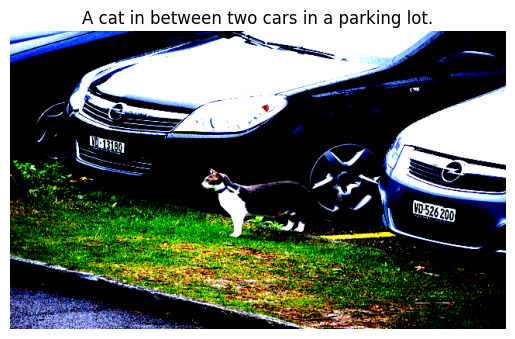

In [48]:
img_path, captions = samples[7]

img = Image.open(img_path)
img_transformed = vilt_transform(img)

tokenized = tokenizer(
    captions,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

img_transformed.shape
plt.imshow(img_transformed.permute(1, 2, 0))
plt.title(captions[0])
plt.axis(False)